Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup # Web Scraper

print("Libraries imported.")

Libraries imported.


Wiki Source - https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Nashville,_Tennessee

Webscraping Nashville neighborhood data from wikipedia

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Nashville,_Tennessee")
soup = BeautifulSoup(res.content, 'lxml')

In [3]:
neigh = []

for row in soup.find("div", class_="mw-category").findAll("li"):
    neigh.append(row.text)

In [4]:
nash_df = pd.DataFrame({"Neighborhood": neigh})

nash_df

,Neighborhood
0,"Antioch, Tennessee"
1,"Bakers, Tennessee"
2,"Bellevue, Tennessee"
3,"Donelson, Tennessee"
4,"East Nashville, Tennessee"
5,"Green Hills, Nashville, Tennessee"
6,"The Gulch, Nashville, Tennessee"
7,"Hermitage, Tennessee"
8,Hillsboro Village
9,"Hopewell, Davidson County, Tennessee"


Some addresses listed will cause arcgis to return inaccurate lat/long values due to their vagueness. Since the dataset is not too large, we can manually specify the ones that will cause problems later on.

In [71]:
nash_df.iloc[0, nash_df.columns.get_loc('Neighborhood')] = 'Antioch, Nashville, Tennessee'
nash_df.iloc[2, nash_df.columns.get_loc('Neighborhood')] = 'Bellevue, Nashville, Tennessee'
nash_df.iloc[12, nash_df.columns.get_loc('Neighborhood')] = 'Lakewood, Nashville, Tennessee'
nash_df.iloc[17, nash_df.columns.get_loc('Neighborhood')] = 'Richland West End Historic District, Nashville, Tennessee'

nash_df

,Neighborhood
0,"Antioch, Nashville, Tennessee"
1,"Bakers, Tennessee"
2,"Bellevue, Nashville, Tennessee"
3,"Donelson, Tennessee"
4,"East Nashville, Tennessee"
5,"Green Hills, Nashville, Tennessee"
6,"The Gulch, Nashville, Tennessee"
7,"Hermitage, Tennessee"
8,Hillsboro Village
9,"Hopewell, Davidson County, Tennessee"


Import necessary libraries

In [5]:
# !conda install -c conda-forge geopy --yes
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import geocoder

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [72]:
# returns coordinates given the address
def getLoc(neigh):
    coords = None
    while(coords is None):
        g = geocoder.arcgis('{}'.format(neigh))
        coords = g.latlng
    return coords

In [73]:
coords = [getLoc(neigh) for neigh in nash_df["Neighborhood"]]

# Create coordinate dataframe
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# Create dataframe with neighborhoods and location info
nash_loc_df = nash_df.join(df_coords)

nash_loc_df

,Neighborhood,Latitude,Longitude
0,"Antioch, Nashville, Tennessee",36.04256,-86.64971
1,"Bakers, Tennessee",36.37219,-86.75999
2,"Bellevue, Nashville, Tennessee",36.07383,-86.93535
3,"Donelson, Tennessee",36.16743,-86.66331
4,"East Nashville, Tennessee",36.17256,-86.75972
5,"Green Hills, Nashville, Tennessee",36.10465,-86.81473
6,"The Gulch, Nashville, Tennessee",36.15273,-86.78371
7,"Hermitage, Tennessee",36.19985,-86.62067
8,Hillsboro Village,36.13467,-86.80647
9,"Hopewell, Davidson County, Tennessee",36.22463,-86.62561


In [74]:
# Geographical coordinate of Nashville
address = 'Nashville, Tennessee'

geolocator = Nominatim(user_agent="nashville")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Nashville, Tennessee are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Nashville, Tennessee are 36.1622296, -86.7743531.


In [75]:
# create map of Toronto using latitude and longitude values
map_nash = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(nash_loc_df['Latitude'], nash_loc_df['Longitude'], nash_loc_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_nash)  
    
map_nash

In [19]:
CLIENT_ID = 'CLIENT_ID'
CLIENT_SECRET = 'CLIENT_SECRET'
VERSION = '20200517'

In [76]:
def getNearbyVenues(names, latitudes, longitudes, Categories, radius=500, LIMIT=100,):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            Categories)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [77]:
nash_venues = getNearbyVenues(names=nash_loc_df['Neighborhood'],
                                   latitudes=nash_loc_df['Latitude'],
                                   longitudes=nash_loc_df['Longitude'],
                                   Categories= '4d4b7105d754a06374d81259'
                                  )

Antioch, Nashville, Tennessee
Bakers, Tennessee
Bellevue, Nashville, Tennessee
Donelson, Tennessee
East Nashville, Tennessee
Green Hills, Nashville, Tennessee
The Gulch, Nashville, Tennessee
Hermitage, Tennessee
Hillsboro Village
Hopewell, Davidson County, Tennessee
Inglewood, Nashville, Tennessee
Joelton, Tennessee
Lakewood, Nashville, Tennessee
Lockeland Springs
Madison, Tennessee
Old Hickory, Tennessee
Pasquo, Tennessee
Richland West End Historic District, Nashville, Tennessee
Tusculum, Nashville, Tennessee
Whites Creek, Tennessee


In [78]:
print(nash_venues.shape)
nash_venues.head()

(167, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Antioch, Nashville, Tennessee",36.04256,-86.64971,Wendy’s,36.044098,-86.649371,Fast Food Restaurant
1,"Antioch, Nashville, Tennessee",36.04256,-86.64971,New Century Buffet,36.040905,-86.650686,Chinese Restaurant
2,"Bakers, Tennessee",36.37219,-86.75999,Daddy O's Pizza,36.368933,-86.757378,Pizza Place
3,"Bellevue, Nashville, Tennessee",36.07383,-86.93535,McDonald's,36.070457,-86.936172,Fast Food Restaurant
4,"Bellevue, Nashville, Tennessee",36.07383,-86.93535,Laissez Les Bon Temps Rouler Eu Cajun's,36.077054,-86.935122,Cajun / Creole Restaurant


In [79]:
nash_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Antioch, Nashville, Tennessee",2,2,2,2,2,2
"Bakers, Tennessee",1,1,1,1,1,1
"Bellevue, Nashville, Tennessee",2,2,2,2,2,2
"Donelson, Tennessee",7,7,7,7,7,7
"East Nashville, Tennessee",14,14,14,14,14,14
"Green Hills, Nashville, Tennessee",38,38,38,38,38,38
"Hermitage, Tennessee",5,5,5,5,5,5
Hillsboro Village,8,8,8,8,8,8
"Hopewell, Davidson County, Tennessee",1,1,1,1,1,1


In [80]:
# one hot encoding
nash_onehot = pd.get_dummies(nash_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nash_onehot['Neighborhood'] = nash_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nash_onehot.columns[-1]] + list(nash_onehot.columns[:-1])
nash_onehot = nash_onehot[fixed_columns]

nash_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,...,Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Wings Joint
0,"Antioch, Nashville, Tennessee",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Antioch, Nashville, Tennessee",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bakers, Tennessee",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Bellevue, Nashville, Tennessee",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bellevue, Nashville, Tennessee",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
nash_onehot.shape

(167, 42)

In [82]:
nash_grouped = nash_onehot.groupby('Neighborhood').mean().reset_index()
nash_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,...,Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Wings Joint
0,"Antioch, Nashville, Tennessee",0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,"Bakers, Tennessee",0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,"Bellevue, Nashville, Tennessee",0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,"Donelson, Tennessee",0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"East Nashville, Tennessee",0.071429,0.000000,0.071429,0.000,0.071429,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.0
5,"Green Hills, Nashville, Tennessee",0.105263,0.026316,0.000000,0.000,0.052632,0.000000,0.000000,0.000000,0.026316,...,0.000000,0.078947,0.000000,0.026316,0.000000,0.026316,0.026316,0.000000,0.026316,0.0
6,"Hermitage, Tennessee",0.200000,0.200000,0.000000,0.000,0.000000,0.000000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,Hillsboro Village,0.125000,0.125000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0
8,"Hopewell, Davidson County, Tennessee",0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,"Inglewood, Nashville, Tennessee",0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [87]:
num_top_venues = 5

for hood in nash_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nash_grouped[nash_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antioch, Nashville, Tennessee----
                  venue  freq
0  Fast Food Restaurant   0.5
1    Chinese Restaurant   0.5
2   American Restaurant   0.0
3      Ramen Restaurant   0.0
4   Japanese Restaurant   0.0


----Bakers, Tennessee----
                 venue  freq
0          Pizza Place   1.0
1  American Restaurant   0.0
2        Hot Dog Joint   0.0
3   Italian Restaurant   0.0
4  Japanese Restaurant   0.0


----Bellevue, Nashville, Tennessee----
                       venue  freq
0  Cajun / Creole Restaurant   0.5
1       Fast Food Restaurant   0.5
2        American Restaurant   0.0
3        Japanese Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Donelson, Tennessee----
                venue  freq
0         Pizza Place  0.43
1    Greek Restaurant  0.14
2           Gastropub  0.14
3  Seafood Restaurant  0.14
4      Sandwich Place  0.14


----East Nashville, Tennessee----
                 venue  freq
0           Restaurant  0.14
1  American Restaurant  0.07
2       

In [88]:
# Sort venues in desc order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [91]:
# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighborhood'] = nash_grouped['Neighborhood']

for ind in np.arange(nash_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nash_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Antioch, Nashville, Tennessee",Fast Food Restaurant,Chinese Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Cajun / Creole Restaurant,Café
1,"Bakers, Tennessee",Pizza Place,Wings Joint,Food Truck,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant,Cajun / Creole Restaurant,Café
2,"Bellevue, Nashville, Tennessee",Fast Food Restaurant,Cajun / Creole Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Chinese Restaurant,Café
3,"Donelson, Tennessee",Pizza Place,Seafood Restaurant,Sandwich Place,Greek Restaurant,Gastropub,Bakery,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega
4,"East Nashville, Tennessee",Restaurant,Greek Restaurant,Pizza Place,BBQ Joint,Bakery,Café,Donut Shop,Food,Fried Chicken Joint,New American Restaurant


In [99]:
from matplotlib import pyplot as plt
print("Libraries imported.")

Libraries imported.


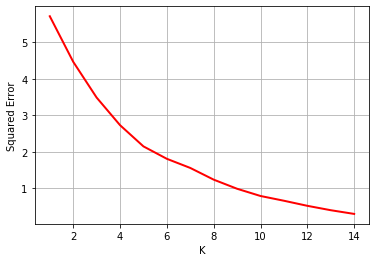

In [105]:
nash_grouped_clustering = nash_grouped.drop('Neighborhood', 1)

squared_error = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, max_iter=200,random_state=0)
    kmeans.fit(nash_grouped_clustering)

    squared_error.append(kmeans.inertia_)

plt.plot(range(1,15), squared_error, color = 'r',linewidth = '2')
plt.xlabel("K")
plt.ylabel("Squared Error")
plt.grid()
plt.show()

In [114]:
# Run K-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nash_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 4, 0, 0, 0, 0, 0, 1, 0])

In [123]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

nash_merged = nash_loc_df

# merge nash_grouped with nash_data to add latitude/longitude for each neighborhood
nash_merged = nash_merged.join(neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nash_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Antioch, Nashville, Tennessee",36.04256,-86.64971,4.0,Fast Food Restaurant,Chinese Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Cajun / Creole Restaurant,Café
1,"Bakers, Tennessee",36.37219,-86.75999,2.0,Pizza Place,Wings Joint,Food Truck,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant,Cajun / Creole Restaurant,Café
2,"Bellevue, Nashville, Tennessee",36.07383,-86.93535,4.0,Fast Food Restaurant,Cajun / Creole Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Chinese Restaurant,Café
3,"Donelson, Tennessee",36.16743,-86.66331,0.0,Pizza Place,Seafood Restaurant,Sandwich Place,Greek Restaurant,Gastropub,Bakery,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega
4,"East Nashville, Tennessee",36.17256,-86.75972,0.0,Restaurant,Greek Restaurant,Pizza Place,BBQ Joint,Bakery,Café,Donut Shop,Food,Fried Chicken Joint,New American Restaurant


In [124]:
nash_merged = nash_merged.dropna()

In [125]:
nash_merged['Cluster_Labels'] = nash_merged.Cluster_Labels.astype(int)

In [126]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nash_merged['Latitude'], nash_merged['Longitude'], nash_merged['Neighborhood'], nash_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [140]:
nash_merged.loc[nash_merged['Cluster_Labels'] == 0, nash_merged.columns[[0] + list(range(4, nash_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Donelson, Tennessee",Pizza Place,Seafood Restaurant,Sandwich Place,Greek Restaurant,Gastropub,Bakery,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega
4,"East Nashville, Tennessee",Restaurant,Greek Restaurant,Pizza Place,BBQ Joint,Bakery,Café,Donut Shop,Food,Fried Chicken Joint,New American Restaurant
5,"Green Hills, Nashville, Tennessee",American Restaurant,Mexican Restaurant,Pizza Place,Sandwich Place,Mediterranean Restaurant,Greek Restaurant,Bakery,Snack Place,Thai Restaurant,Asian Restaurant
6,"The Gulch, Nashville, Tennessee",Restaurant,American Restaurant,Steakhouse,Café,Sandwich Place,Deli / Bodega,Burger Joint,Gastropub,Pizza Place,Mexican Restaurant
7,"Hermitage, Tennessee",American Restaurant,Breakfast Spot,Food Truck,Fried Chicken Joint,Asian Restaurant,Bagel Shop,Bakery,Bistro,BBQ Joint,Buffet
8,Hillsboro Village,American Restaurant,Bagel Shop,Hot Dog Joint,Italian Restaurant,Noodle House,Fried Chicken Joint,Asian Restaurant,Sushi Restaurant,Bakery,Chinese Restaurant
10,"Inglewood, Nashville, Tennessee",Pizza Place,Fast Food Restaurant,Seafood Restaurant,Mexican Restaurant,Fried Chicken Joint,Burrito Place,Food,Donut Shop,Deli / Bodega,Chinese Restaurant
12,"Lakewood, Nashville, Tennessee",Thai Restaurant,Bistro,Breakfast Spot,Cajun / Creole Restaurant,Fried Chicken Joint,Food Truck,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega
13,Lockeland Springs,American Restaurant,Pizza Place,Food,Bakery,Mexican Restaurant,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant,Cajun / Creole Restaurant
14,"Madison, Tennessee",Wings Joint,Pizza Place,BBQ Joint,Bakery,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Italian Restaurant,American Restaurant,Seafood Restaurant


In [137]:
nash_merged.loc[nash_merged['Cluster_Labels'] == 1, nash_merged.columns[[0] + list(range(4, nash_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Hopewell, Davidson County, Tennessee",Hot Dog Joint,Wings Joint,Café,Food Truck,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant,Cajun / Creole Restaurant


In [138]:
nash_merged.loc[nash_merged['Cluster_Labels'] == 2, nash_merged.columns[[0] + list(range(4, nash_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Bakers, Tennessee",Pizza Place,Wings Joint,Food Truck,Food,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant,Cajun / Creole Restaurant,Café


In [136]:
nash_merged.loc[nash_merged['Cluster_Labels'] == 3, nash_merged.columns[[0] + list(range(4, nash_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,"Pasquo, Tennessee",Southern / Soul Food Restaurant,BBQ Joint,Food,Wings Joint,Café,Food Truck,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant
19,"Whites Creek, Tennessee",Food,Southern / Soul Food Restaurant,Cajun / Creole Restaurant,Wings Joint,Burrito Place,Food Truck,Fast Food Restaurant,Donut Shop,Deli / Bodega,Chinese Restaurant


In [139]:
nash_merged.loc[nash_merged['Cluster_Labels'] == 4, nash_merged.columns[[0] + list(range(4, nash_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Antioch, Nashville, Tennessee",Fast Food Restaurant,Chinese Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Cajun / Creole Restaurant,Café
2,"Bellevue, Nashville, Tennessee",Fast Food Restaurant,Cajun / Creole Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Chinese Restaurant,Café
11,"Joelton, Tennessee",Fast Food Restaurant,Wings Joint,Gastropub,Food Truck,Food,Donut Shop,Deli / Bodega,Chinese Restaurant,Cajun / Creole Restaurant,Café
